In [1]:
import numpy as np
from rngs import random, plantSeeds, selectStream
import matplotlib.pyplot as plt

In [2]:
def Uniform(a,b):
    return (a + (b - a) * random())

Given the need for an average of 1000 customers per hour, there are 3600 seconds in an hour and therefore a new customer must arrive every 3.6 seconds. We therfore proceed with customers average arrival being between 0 to 7.2 seconds to achieve this rate of customer entrance.

In [3]:
def customer_arrivals(avg_t):
    #we create a list of random times for an average of 1000 customers per hour.
    c_time = 0
    #list of arrival times
    loat = []
    while c_time < 10800:
        
        #the -2/3000 is to compensate for the removal of the any customers from the queue after 2pm
        #this ensures we have an average of 3000 customers per day
        
        c_time += Uniform(0,avg_t*2 - 2/3000)
        if c_time < 10800:
            loat.append(c_time)
    return loat
 
# The function has been defined in such a way so that no customers can appear before t=0 (11am) 
# or after t = 3 (2pm)  

## The Model

There are two main ways to approach the task of simulating the coffeeshop. You can have a time variable which runs from the start of the day until the end, with a random chance of a customer appearing at any given time, the total averaging 1000 customers per hour. At every time instance you would check if a new customer arrives, if any workers are now free and if there is a queue for them to serve. Alternatively you can generate an updating list of only the important events of the day, which is the method taken below. We generate a list of random times when customers enter the shop (Next Event Simulation). These are counted as important events when we need to check availability. We then dynamically add new important events : when a staff member will become free to serve a customer again. Checking availabilty at these times covers all possible specified cases.

In [4]:
class staff:
    def __init__(self, B):
        self.staff_id = Uniform(0, 10)
        self.free = True
        self.nextfreetime = 0
        self.coffees_made = 0
        self.total_time_worked = 0
        self.queue = []
        self.B = B
        
    def __lt__(self, other):
         return self.nextfreetime < other.nextfreetime
        
    def serving(self, ct):
        self.free = False
        # adds a B chance to have to remake the coffee order
        if Uniform(0, 1) < self.B:
            time_to_make_coffee = 2*Uniform(20, 40)
        else:
            time_to_make_coffee = Uniform(20, 40)
              
        self.nextfreetime = ct + time_to_make_coffee
        self.total_time_worked += time_to_make_coffee
            
    def canwork(self, ct):
        if ct >= self.nextfreetime:
            self.free = True
            
    def nft(self):
        return self.nextfreetime

In [5]:
class coffeeshop:
    def __init__(self,n, B, Q, QC, events):
        self.nstaff = n
        self.wage = 25*(1-B)
        self.iter = 0
        self.available_workers = [staff(B) for _ in range(n)]
        self.events = events
        self.queue = []
        self.queue_capacity = QC
        self.profit = 0
        self.net_profit = 0
        self.queue_wait_time = []
        self.turned_away_customers = 0
        self.queue_use = Q # Set as false for no queue limit
        
    def update_availability(self, ct):
        for i in self.available_workers:
            i.canwork(ct) 
     
    def add_2_q(self, ct):
        if self.queue_use:
            if len(self.queue) <  self.queue_capacity:

                self.queue.append(ct)
            else:
                self.turned_away_customers += 1
        
        elif self.queue_use == False:
            self.queue.append(ct)


    #adds a new event and ensures each event occurs chronologivally
    # must sort after each event due to randomness of when workers finish a job
    def update_events(self, event):
        self.events = np.append(np.array(self.events) , event, axis = 0)
        self.events = self.events[np.argsort(self.events[:, 0])]
        
            
    def assign_worker_nc(self, ct):
        # If the worker with the lowest next free time is not free, the rest will not be free,
        # so we only check if the 1st worker is free before adding a new customer to the queue
        if len(self.queue) == 0:
            worker = self.available_workers[0]
            if worker.free:
                worker.serving(ct)
                
                # Every time a worker gets assigned a job we must re-order the availability 
                # due to the fact that one worker could finish a job before another, desite starting later
                self.available_workers.sort()
                self.profit += 0.5
                
                #If the worker serves a customer, we add a new event for when the worker will be free again
                temp = [worker.nft(), 0]
                self.update_events(np.array([temp]))
                
            else:
                self.add_2_q(ct)
                
            
            # if there are no workers free and noone in the queue we add this customer to the queue
        elif len(self.queue) > 0:
            self.add_2_q(ct)
                
    def assign_worker_nwf(self, ct):
        #this funciton applies to when a new worker is free to deal with customers in the queue
        self.update_availability(ct)
     
        worker = self.available_workers[0]
        worker.serving(ct)
        self.available_workers.sort()
        self.profit += 0.5
        temp = [worker.nft(), 0]
        self.update_events(np.array([temp]))
                                 

    # This program runs when either a new customer enters the shop, or a staff member is now free to 
    # serve customers in the queue
    def new_event(self, event):
        self.update_availability(event[0])
        self.available_workers.sort()
        # handling an event whereby a new customer enters the shop
        if event[1] == 1:
            self.assign_worker_nc(event[0])           
        
        # Handling event where a worker becomes available, which checks if there is anyone in the 
        # queue and serves them if there is 
        if event[1] == 0:
            if len(self.queue) > 0:
                # Assigns a worker using the time they became free
                self.assign_worker_nwf(event[0])
                self.queue_wait_time.append(event[0] - self.queue[0])
                self.queue.remove(self.queue[0])
                       
                
    def run_shop(self):
        iter = 0
        while iter < len(self.events):
            self.new_event(self.events[iter])
            iter += 1
        self.iter = iter
        self.net_profit = self.profit - self.wage*3*self.nstaff
        
        
    def shop_day_stats(self):
        print("\nDay finished!")
        print("\nTotal Gross Profit is : €", self.profit)
        print("\nTotal Net Profit is : €", self.net_profit)
        print("\nTotal Customers Served : ", self.profit*2)
        print("\nTotal number of customers who entered the queue : ", len(self.queue_wait_time))

        if len(self.queue_wait_time) != 0:
            print("\nAverage Queue time : {:.2f} Minutes \n".format(sum(self.queue_wait_time)/(len(self.queue_wait_time)*60), " minutes \n"))
        for i in range(self.nstaff):
            pop_worked = self.available_workers[i].total_time_worked / 10800
            print("Worker ", i+1, " had utilisation of : ", pop_worked)
        
        if self.queue_use: 
            print("\nTotal customers turned Away : ", self.turned_away_customers)
            print("\nLost profit due to turned away customers : €", self.turned_away_customers/2)

                          

## Testing validity of customer generating method

We desire a method of customer generating which will deliver on average 3000 customers over three hours, evenly spread. Below we perform some rudimentary tests to show that our customer generating methods meets the desired criteria.

The average number of customers per day is  3000.252


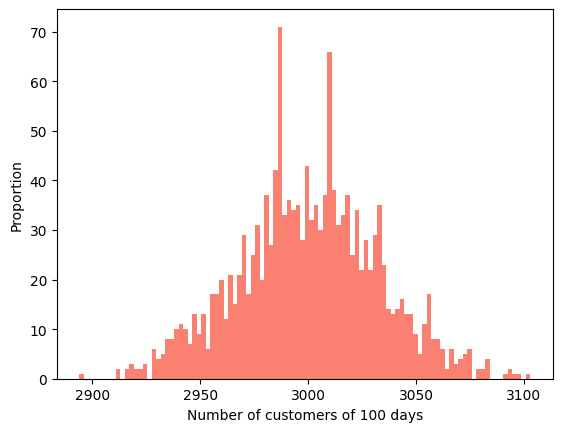

In [6]:
plantSeeds(123456789)

avg_customer_numers = [len(customer_arrivals(3.6)) for _ in range(1500)]

plt.hist(avg_customer_numers, density=False, bins=100, color='salmon')  
plt.ylabel('Proportion')
plt.xlabel('Number of customers of 100 days');
print("The average number of customers per day is " , sum(avg_customer_numers)/1500)

This is clearly an gaussian distrobution (as we have coded using the Uniform distrobution function) with mean 3000. This indicates our day to day customer numbers are uniformly random. We could increase the variance as a function of the range of the Uniform function generating the times of arrival of customers, however this will not effect conclusions drawn from large datasets as we will use to test hypothesis. We therefore shall ignore variance as an metric.

The average number of customers per day is  2999.9066666666668


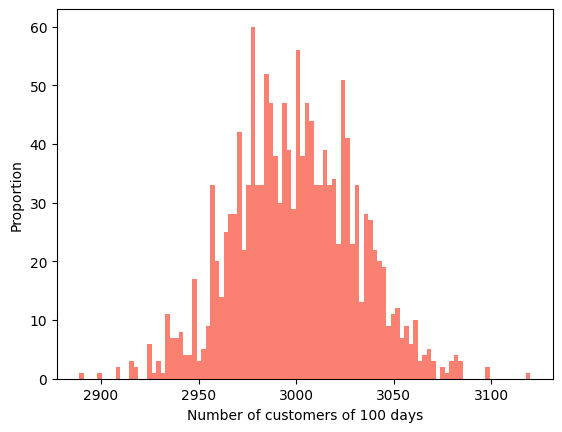

In [7]:
plantSeeds(3)

avg_customer_numers = [len(customer_arrivals(3.6)) for _ in range(1500)]

plt.hist(avg_customer_numers, density=False, bins=100, color='salmon')  
plt.ylabel('Proportion')
plt.xlabel('Number of customers of 100 days');
print("The average number of customers per day is " , sum(avg_customer_numers)/1500)

The average number of customers per day is  2999.0553333333332


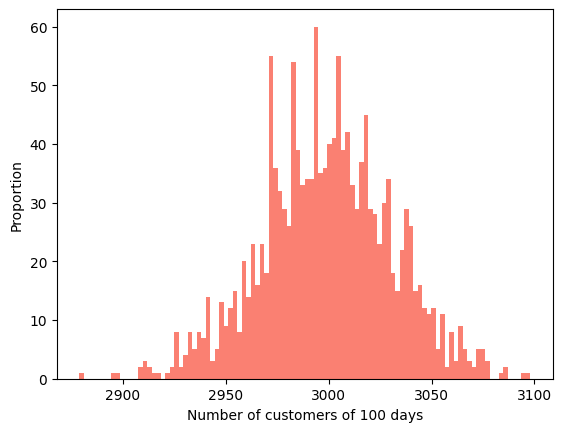

In [8]:
plantSeeds(100)

avg_customer_numers = [len(customer_arrivals(3.6)) for _ in range(1500)]

plt.hist(avg_customer_numers, density=False, bins=100, color='salmon')  
plt.ylabel('Proportion')
plt.xlabel('Number of customers of 100 days');
print("The average number of customers per day is " , sum(avg_customer_numers)/1500)

As can be seen the seed chosen appears to affect the distrobution of customers. This can impact our model as distrobutions with more days havinig customers above 3000 will disproportionally affect the performance of coffee shop models with lower average serving rates (they will have more customers lost due to the queue lengths being to high). Similarly models with high variance will have more days with low customers, which will results in more wasted time per employee for coffeeshops with a higher average serving time (higher cost of wages per cofffee). In sum, higher variance seeds will result in greater discrepency in performance between different models. We proceed testing with the seed 123456789 as specified. 

The average time of customers per day is  5401.559728227264


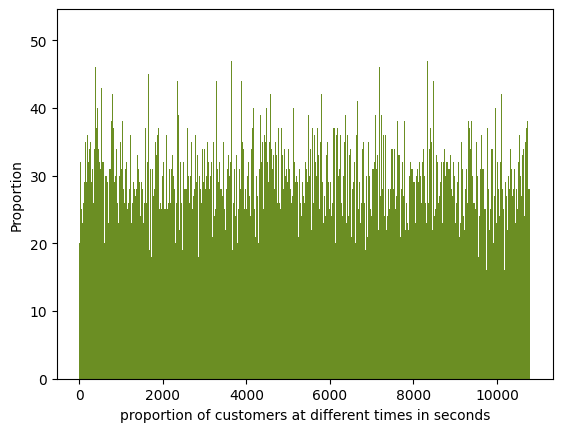

In [9]:
plantSeeds(123456789)

avg_customer_times = []
for _ in range(200):
    avg_customer_times = avg_customer_times + customer_arrivals(3.6)


plt.hist(avg_customer_times, density=False, bins=20000, color='olivedrab')  
plt.ylabel('Proportion')
plt.xlabel('proportion of customers at different times in seconds');
print("The average time of customers per day is " , sum(avg_customer_times)/len(avg_customer_times))

The mean of this set of customer times is 5400, this is exactly half of 10800, which is the total number of seconds in the day. This means that on average there are as many customers in the 1st half of the day as the 2nd. The flatness graph also indicates a roughly uniform distrobution of times between customers entering the shop. This however does not mean there are times where a relativly high volume of customers enteing the shop at certain times. The fucntion below can be used to show small fluctions in times between the 1st and 2nd 50 customers.

In [11]:
Average_tuesday = customer_arrivals(3.6)

print("It took {:.2f} minutes for the 1st 50 customers to arrive and \n {:.2f} minutes for the 2nd 50 customers to arrive".format(Average_tuesday[50]/60, (Average_tuesday[100] - Average_tuesday[50])/60))


It took 2.95 minutes for the 1st 50 customers to arrive and 
 2.62 minutes for the 2nd 50 customers to arrive


## Control Tuesday - testing model and implementing a queue

We shall model an average tuesday worth of customers, with an unlimited number of people willing to wait in the queue.

In [12]:
cust_arrival_times = []
for i in Average_tuesday:
     cust_arrival_times.append((i, 1))
    
cust_arrival_times = np.array(cust_arrival_times)
    
noq_coffeeshop = coffeeshop(7, 0, False, 200 ,np.array(cust_arrival_times))
print("Total customers which will arrive at coffee shop is : ", len(Average_tuesday))

Total customers which will arrive at coffee shop is :  3002



Day finished!

Total Gross Profit is : € 1501.0

Total Net Profit is : € 976.0

Total Customers Served :  3002.0

Total number of customers who entered the queue :  2995

Average Queue time : 16.67 Minutes 

Worker  1  had utilisation of :  1.1914032304817788
Worker  2  had utilisation of :  1.1919550316560537
Worker  3  had utilisation of :  1.1916562231813719
Worker  4  had utilisation of :  1.193038875414094
Worker  5  had utilisation of :  1.193727718349385
Worker  6  had utilisation of :  1.193243532905795
Worker  7  had utilisation of :  1.1948652861012319


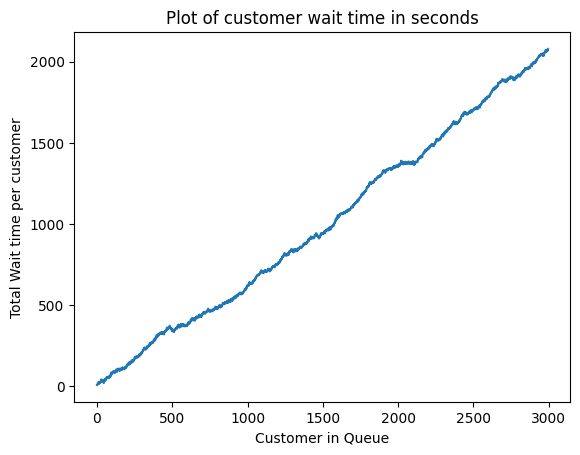

In [13]:
noq_coffeeshop.run_shop()
noq_coffeeshop.shop_day_stats()
plt.title('Plot of customer wait time in seconds')
plt.ylabel('Total Wait time per customer')
plt.xlabel('Customer in Queue');
plt.plot(np.arange(len(noq_coffeeshop.queue_wait_time)), noq_coffeeshop.queue_wait_time)

As we can see by the average queue time and by scrolling through the events taking place, having an unlimited 
queue system leads to ridiculous results. The higher than 1 utilisation of the workers means they worked almost 20% unpaid overtime. Further the graph shown above indicates that the staff were unable to keep up with the number of customers entering the shop as the queue time experienced by each customer increased over time.


Day finished!

Total Gross Profit is : € 1366.5

Total Net Profit is : € 841.5

Total Customers Served :  2733.0

Total number of customers who entered the queue :  2726

Average Queue time : 10.87 Minutes 

Worker  1  had utilisation of :  1.078693878443269
Worker  2  had utilisation of :  1.0806722435622198
Worker  3  had utilisation of :  1.0799271818553644
Worker  4  had utilisation of :  1.0799047014530714
Worker  5  had utilisation of :  1.0795972792043518
Worker  6  had utilisation of :  1.0806263380128085
Worker  7  had utilisation of :  1.0812427257479749

Total customers turned Away :  269

Lost profit due to turned away customers : € 134.5


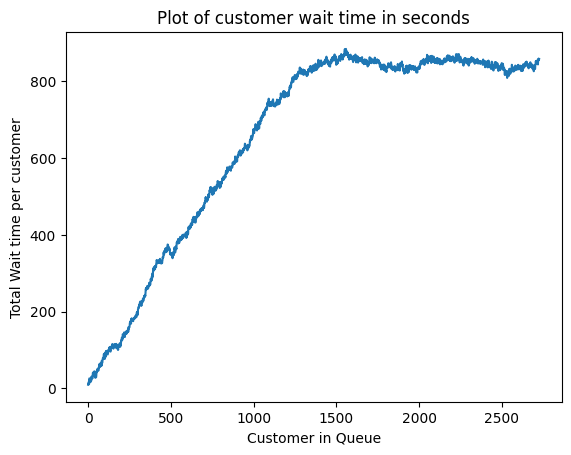

In [14]:
wq_coffeeshop = coffeeshop(7, 0, True, 200 ,np.array(cust_arrival_times))
wq_coffeeshop.run_shop()
wq_coffeeshop.shop_day_stats()

plt.title('Plot of customer wait time in seconds')
plt.ylabel('Total Wait time per customer')
plt.xlabel('Customer in Queue');
plt.plot(np.arange(len(wq_coffeeshop.queue_wait_time)), wq_coffeeshop.queue_wait_time)

As we can see, by implementing a queue on the same dataset, the workers reduced the average queue time by turning customers away. They decreased how long they have to work after hours at the cost of some profit.

## Optimising for Profit

Below we loop through a range of staffing senarios to determine the most profitable staffing arangement. Given the random nature of the performance of staff day by day even with the same customer arrival tiimes, running the same staffing and wage arrangement on the same dataset of customers entering will yield random results. We shall therefore test several arrangements and analyse results graphicall to narrow down our search before making statistically significant results.

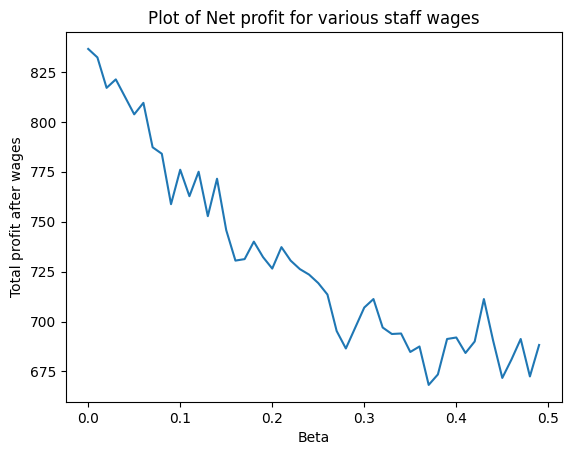

In [15]:
#testing for n = 6 workers

listofn6profits = []

for i in np.arange(0, 0.5, 0.01):
    n6cs = coffeeshop(7, i, True, 200 ,np.array(cust_arrival_times))
    n6cs.run_shop()
    listofn6profits.append(n6cs.net_profit)
    
plt.title('Plot of Net profit for various staff wages')
plt.ylabel('Total profit after wages')
plt.xlabel('Beta');
plt.plot(np.arange(0, 0.5, 0.01), listofn6profits)   

Given the maximum profit per day is achieved with employing the best and most expensive workers, we can conclude that the main source of loss while the coffee shop employees 6 staff is customers not being served. We can therefore expect to see similar results for staff numbers of 7 and 8 as both of those have over 100% utilisation of each worker throughout the day.

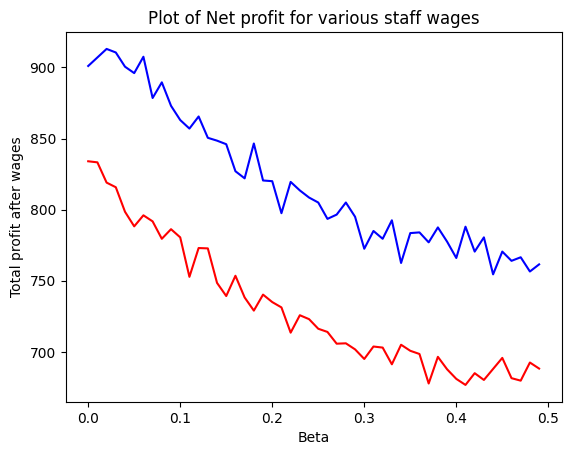

In [16]:
listofn7profits = []
listofn8profits = []

for i in np.arange(0, 0.5, 0.01):
    n7cs = coffeeshop(7, i, True, 200 ,np.array(cust_arrival_times))
    n8cs = coffeeshop(8, i, True, 200 ,np.array(cust_arrival_times))
    n7cs.run_shop()
    n8cs.run_shop()
    listofn7profits.append(n7cs.net_profit)
    listofn8profits.append(n8cs.net_profit)
    
    
plt.title('Plot of Net profit for various staff wages')
plt.ylabel('Total profit after wages')
plt.xlabel('Beta');
plt.plot(np.arange(0, 0.5, 0.01), listofn7profits, "r")  
plt.plot(np.arange(0, 0.5, 0.01), listofn8profits, "b")   

Contrary to our prediction we obseve a peak or profit for a Beta slightly larger than 0 when 8 workers are working in the shop.

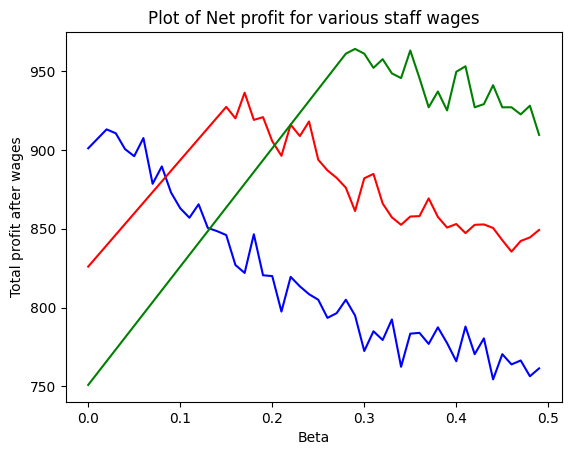

In [17]:
listofn9profits = []
listofn10profits = []

for i in np.arange(0, 0.5, 0.01):
    n9cs = coffeeshop(9, i, True, 200 ,np.array(cust_arrival_times))
    n10cs = coffeeshop(10, i, True, 200 ,np.array(cust_arrival_times))
    n9cs.run_shop()
    n10cs.run_shop()
    listofn9profits.append(n9cs.net_profit)
    listofn10profits.append(n10cs.net_profit)
    
    
plt.title('Plot of Net profit for various staff wages')
plt.ylabel('Total profit after wages')
plt.xlabel('Beta')
 
plt.plot(np.arange(0, 0.5, 0.01), listofn8profits, "b") 
plt.plot(np.arange(0, 0.5, 0.01), listofn9profits, "r")  
plt.plot(np.arange(0, 0.5, 0.01), listofn10profits, "g") 
plt.show()



Clearly the maximum profits are achieved with some arrangement of 10 workers. Given the complexity of the system, it is difficult to obtain an analytic model to perform calculus on. We therefore will estimate experimentally the optimum Beta for net profit. We check incriments of €0.01 as you cannot pay someone less than 1c.

The Beta which return the highest profit with 10 workers is 0.29


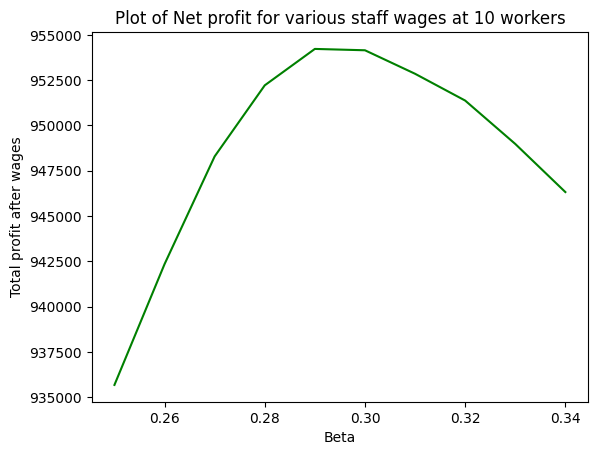

In [18]:
Golbal_Beta = [0]*10


for i in range(100):
    temp_arrival_times = customer_arrivals(3.6)
    B_arriavl_Times = [(i, 1) for i in temp_arrival_times]
    for j in range(10):
        Bcoffeeshops = [coffeeshop(10, B, True, 200 ,np.array(B_arriavl_Times)) for B in np.arange(0.25, 0.35, 0.01)]
        for k in Bcoffeeshops:
            k.run_shop()
            index = Bcoffeeshops.index(k)
            Golbal_Beta[index] += k.net_profit
        
        
max_B = max(Golbal_Beta)
b_index = Golbal_Beta.index(max_B)
        
print("The Beta which return the highest profit with 10 workers is {}".format(b_index/100 + 0.25))

    
plt.title('Plot of Net profit for various staff wages at 10 workers')
plt.ylabel('Total profit after wages')
plt.xlabel('Beta')
  
plt.plot(np.arange(0.25, 0.35, 0.01), Golbal_Beta, "g") 
plt.show()       

This code tests each 10 worker payment setup on 3 million customers each, this is almost 3 years of continuous running for each coffeeshop with them all being tested with the same set of customers multiple times to reduce variance.

## Optimising for queue time

Clearly there are several different setups which can obtain a queue time of less than 2 minutes in average. Below we discern wavge arrangements for various worker numbers to achieve this. 

In [19]:
w8q_coffeeshop = coffeeshop(8, 0, True, 200 ,np.array(cust_arrival_times))
w8q_coffeeshop.run_shop()
w8q_coffeeshop.shop_day_stats()


Day finished!

Total Gross Profit is : € 1501.0

Total Net Profit is : € 901.0

Total Customers Served :  3002.0

Total number of customers who entered the queue :  2994

Average Queue time : 3.85 Minutes 

Worker  1  had utilisation of :  1.039977837479491
Worker  2  had utilisation of :  1.040179464722618
Worker  3  had utilisation of :  1.040337557984433
Worker  4  had utilisation of :  1.0399598889652872
Worker  5  had utilisation of :  1.0411502974653044
Worker  6  had utilisation of :  1.0425213240862798
Worker  7  had utilisation of :  1.0420238471457988
Worker  8  had utilisation of :  1.041981287162328

Total customers turned Away :  0

Lost profit due to turned away customers : € 0.0


Given that the average wait time in the queue for a coffeeshop with 8 workers is nearly 5 minutes with 0 Beta, there is no arrangement whereby 8 workers or less can achieve an average queue time of 2 minutes. We therefore optimise for 9 and 10 workers.

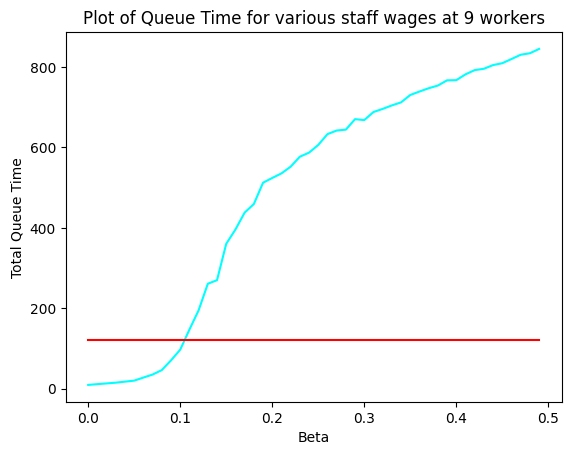

The Lowest wages achived with a queue time under 2 minutes is €22.25 for 9 workers.


In [20]:
Two_minute_mark = [120]*50
Q_times = []
first_above_2 = True
first_above_2_Beta = 0


for B in np.arange(0, 0.5, 0.01):
    avg_queue = 0
    for i in range(10):
        w9q_coffeeshop = coffeeshop(9, B, True, 200 ,np.array(cust_arrival_times))
        w9q_coffeeshop.run_shop()
        avg_queue += (sum(w9q_coffeeshop.queue_wait_time)/len(w9q_coffeeshop.queue_wait_time))
        
    avg_queue = avg_queue/10
    
    Q_times.append(avg_queue)
    
    if first_above_2:
        if avg_queue > 120:
            first_above_2_Beta = B
            first_above_2 = False
            
            
    

plt.title('Plot of Queue Time for various staff wages at 9 workers')
plt.ylabel('Total Queue Time')
plt.xlabel('Beta')
  
plt.plot(np.arange(0, 0.5, 0.01), Q_times, "#00FFFF") 
plt.plot(np.arange(0, 0.5, 0.01), Two_minute_mark, "r") 

plt.show()    
    
print("The Lowest wages achived with a queue time under 2 minutes is €{} for 9 workers.".format( 25*(1-first_above_2_Beta) ) )        


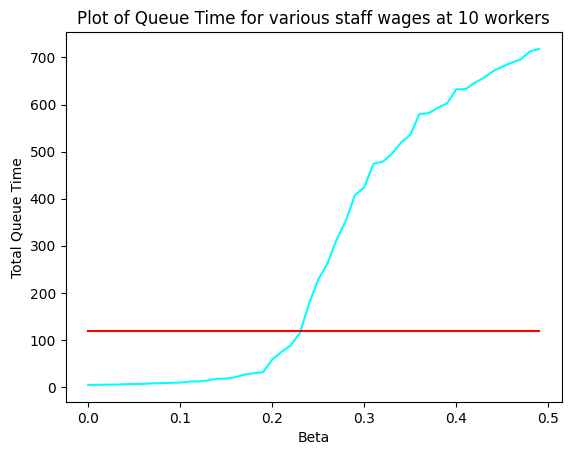

The Lowest wages achived with a queue time under 2 minutes is €19.0 for 10 workers.


In [21]:
Two_minute_mark = [120]*50
Q_times = []
first_above_2 = True
first_above_2_Beta = 0


for B in np.arange(0, 0.5, 0.01):
    avg_queue = 0
    for i in range(10):
        w10q_coffeeshop = coffeeshop(10, B, True, 200 ,np.array(cust_arrival_times))
        w10q_coffeeshop.run_shop()
        avg_queue += (sum(w10q_coffeeshop.queue_wait_time)/len(w10q_coffeeshop.queue_wait_time))
        
    avg_queue = avg_queue/10
    
    Q_times.append(avg_queue)
    
    if first_above_2:
        if avg_queue > 120:
            first_above_2_Beta = B
            first_above_2 = False
            
            
    

plt.title('Plot of Queue Time for various staff wages at 10 workers')
plt.ylabel('Total Queue Time')
plt.xlabel('Beta')
  
plt.plot(np.arange(0, 0.5, 0.01), Q_times, "#00FFFF") 
plt.plot(np.arange(0, 0.5, 0.01), Two_minute_mark, "r") 

plt.show()    
    
print("The Lowest wages achived with a queue time under 2 minutes is €{} for 10 workers.".format( 25*(1-first_above_2_Beta) ) )        